# Final project

Họ tên: Đỗ Liên Khoa          
MSSV: 18120413

# CHẤT LƯỢNG KHÔNG KHÍ
Trong thời đại công nghệ 4.0 hiện nay, việc sử dụng máy móc đã trở thành chuyện không thể tránh khỏi, ngành công nghiệp máy móc đang trở nên phát triển hơn bao giờ hết. Nhưng với sự hoạt động liên tục và mạnh mẽ các loại máy như vậy dẫn đến ô nhiễm không khí rất nghiêm trọng. Ở Việt Nam, chỉ với khói bụi từ xe máy cũng đã ảnh hưởng rất nhiều đến chất lượng không khí. Vậy hiện tại chất lượng không khí ở Thành phố Hồ Chí Minh như thế nào?

Dữ liệu được thu thập từ trang https://openweathermap.org và được lưu vào 2 file air_quality.csv và air_quality_test.csv với:
- air_quality.csv là dữ liệu về chất lượng không khí ở Việt Nam trong khoảng thời gian từ 1/1/2016 tới 31/12/2020
- air_quality_test.csv là dữ liệu về chất lượng không khí ở Việt Nam trong khoảng thời gian từ 1/1/2021 tới 15/1/2021

---

# Gọi các hàm cần thiết

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neural_network import MLPClassifier
from sklearn import set_config
set_config(display='diagram')

---

# Khám phá dữ liệu

In [2]:
df = pd.read_csv('air_quality.csv')
df.head()

,aqi,co,no,no2,o3,so2,pm2_5,pm10,nh3,dt
0,4,627.52,0.01,32.56,51.50,33.85,39.23,45.34,9.63,1609372800
1,4,507.36,0.00,26.39,58.65,30.28,35.06,39.89,8.36,1609369200
2,4,487.33,0.00,23.99,62.23,28.37,33.88,38.21,8.11,1609365600
3,4,500.68,0.00,23.65,62.23,28.13,33.06,37.27,8.36,1609362000
4,4,520.71,0.00,24.33,61.51,28.37,32.21,36.40,8.61,1609358400


Ý nghĩa các thuộc tính:
- aqi: chất lượng không khí, được sắp xếp theo thứ tự từ 1->5 với 1 = Good, 2 = Fair, 3 = Moderate, 4 = Poor, 5 = Very Poor
- co: lượng khí co trong không khí, đơn vị: μg/m3
- no: lượng khí no trong không khí, đơn vị: μg/m3
- no2: lượng khí no2 trong không khí, đơn vị: μg/m3
- o3: lượng khí o3 trong không khí, đơn vị: μg/m3
- so2: lượng khí so2 trong không khí, đơn vị: μg/m3
- pm2_5: lượng bụi mịn có kích thước đường kính từ 2.5 tới 10 µm trong không khí, đơn vị: μg/m3
- pm10: lượng bụi mịn có kích thước đường kính nhỏ hơn hoặc bằng 2,5 µm trong không khí, đơn vị: μg/m3
- nh3: lượng khí nh3 trong không khí, đơn vị: μg/m3
- dt: thời gian đo, được tính theo UNIX time

### Dữ liệu có bao nhiêu dòng và bao nhiêu cột?

In [3]:
df.shape

(864, 10)

### Kiểm tra trùng lặp

In [4]:
df.index.duplicated().sum()

0

Quan sát ta thấy mỗi dòng của dữ liệu thể hiện chất lượng không khí ở một thời điểm nhất định và không có sự trùng lặp trong dữ liệu.

---

### Kiểu dữ liệu của cột output

In [5]:
df['aqi'].dtype

dtype('int64')

### Kiểm tra xem cột output

In [6]:
df['aqi'].isna().sum()

0

### Tỉ lệ các lớp trong cột output

In [7]:
df['aqi'].value_counts(normalize=True) * 100

5    79.513889
4    20.023148
3     0.462963
Name: aqi, dtype: float64

Ta thấy cột kết quả không có vấn đề gì.

---

### Tiền xử lý (tách các tập)

In [8]:
y_sr = df['aqi']
X_df = df.drop('aqi', axis = 1)

In [9]:
#Tách tập theo tỉ lệ 70%:30%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(X_df, y_sr, test_size=0.3, 
                                                              stratify=y_sr, random_state=0)

In [10]:
train_X_df.shape

(604, 9)

In [11]:
train_y_sr.shape

(604,)

In [12]:
val_X_df.shape

(260, 9)

In [13]:
val_y_sr.shape

(260,)

In [14]:
train_X_df.head().index

Int64Index([832, 758, 499, 16, 367], dtype='int64')

### Khám phá tập huấn luyện

In [15]:
train_X_df.dtypes

co       float64
no       float64
no2      float64
o3       float64
so2      float64
pm2_5    float64
pm10     float64
nh3      float64
dt         int64
dtype: object

Các cột đều đã có kiểu dữ liệu phù hợp.

In [16]:
num_df = train_X_df.drop('dt', axis=1)

def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)

num_df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,co,no,no2,o3,so2,pm2_5,pm10,nh3
missing_ratio,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
min,487.33,0.00,14.74,0.00,15.26,21.19,27.80,2.57
lower_quartile,847.80,0.60,31.90,0.60,26.90,55.00,61.20,8.10
median,1101.50,4.00,43.90,14.60,33.80,98.60,108.10,11.30
upper_quartile,2002.70,18.30,59.60,48.80,44.40,184.20,200.10,17.70
max,13137.82,261.07,230.31,174.52,205.99,740.71,818.99,239.13


Vậy là tất cả các cột đều có đủ dữ liệu.

# Tiền xử lý + mô hình hoá

Ta sẽ xoá cột dt vì cột dt chỉ dùng để xác định thời gian thực hiện đo đạc, không ảnh hưởng đến kết quả cuối cùng.

In [17]:
class ColDropper(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X_df, y=None):
        return self
    def transform(self, X_df, y=None):
        return X_df.drop('dt', axis=1)

Tiếp theo ta sẽ sử dụng mô hình Neural Net để phân lớp với các siêu tham số: hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500.
Sau đó ta tiếp tục thử nghiệm với siêu tham số alpha = [0.01, 0.1, 1, 10, 100, 1000].
Vậy tổng cộng ta sẽ thử nghiệm 6 mô hình khác nhau để có thể chọn ra mô hình với độ lỗi nhỏ nhất.

In [18]:
classifier = MLPClassifier(hidden_layer_sizes=(20), activation='tanh', solver='lbfgs', random_state=0, max_iter=2500)

full_pipeline = make_pipeline(ColDropper(), StandardScaler(), classifier)

alphas = [0.01, 0.1, 1, 10, 100, 1000]
train_errs = []
val_errs = []
best_val_err = float('inf')
best_alpha = None

for alpha in alphas:
    full_pipeline.set_params(mlpclassifier__alpha=alpha)
    full_pipeline.fit(train_X_df, train_y_sr)
    train_errs.append((1 - full_pipeline.score(train_X_df, train_y_sr))*100)
    val_err = (1 - full_pipeline.score(val_X_df, val_y_sr))*100
    val_errs.append(val_err)
    if val_err < best_val_err:
        best_val_err = val_err
        best_alpha = alpha
        
'Finish'

'Finish'

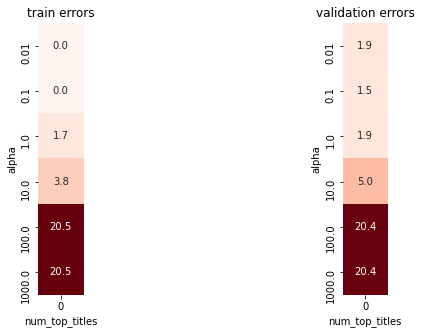

In [19]:
#Trực quan hoá dữ liệu
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('train errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.1f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('num_top_titles'); plt.ylabel('alpha');

In [20]:
#Huấn luyện lại với best_alpha
full_pipeline.set_params(mlpclassifier__alpha=best_alpha)
full_pipeline.fit(train_X_df, train_y_sr)

Pipeline(steps=[('coldropper', ColDropper()),
                ('standardscaler', StandardScaler()),
                ('mlpclassifier',
                 MLPClassifier(activation='tanh', alpha=0.1,
                               hidden_layer_sizes=20, max_iter=2500,
                               random_state=0, solver='lbfgs'))])

In [21]:
#Dùng mô hình vừa học để dự đoán tập test
test_df = pd.read_csv('air_quality_test.csv')
test_df_data = test_df.drop('aqi', axis = 1)
test_df_result = test_df['aqi']

#Tính độ lỗi của kết quả
err = (1-full_pipeline.score(test_df_data, test_df_result)) * 100
print('Độ lỗi =' , err)
full_pipeline.predict(test_df_data)

Độ lỗi = 3.194888178913735


array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,

Vậy với độ lỗi của mô hình là 3,195%, ta thấy được rằng chất lượng không khí của thành phố Hồ Chí Minh trong khoảng thời gian đầu năm là rất thấp (4 = Poor, 5 = Very Poor).